In [1]:
import pandas as pd
import numpy as np
import os

# File path
file_path = os.path.join("./", "superstore.csv")

# Load the dataset with encoding fix
df = pd.read_csv(file_path, encoding='ISO-8859-1')

# Fix data types
df['Order Date'] = pd.to_datetime(df['Order Date'], errors='coerce')
df['Ship Date'] = pd.to_datetime(df['Ship Date'], errors='coerce')

categorical_cols = ['Category', 'Sub-Category', 'Segment', 'Region', 'Ship Mode', 'City', 'State', 'Country']
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype('category')

# Quick preview
print(df.dtypes)
df.head()


Row ID                         int64
Order ID                      object
Order Date            datetime64[ns]
Ship Date             datetime64[ns]
Ship Mode                   category
Customer ID                   object
Customer Name                 object
Segment                     category
Country                     category
City                        category
State                       category
Postal Code                    int64
Region                      category
Product ID                    object
Category                    category
Sub-Category                category
Product Name                  object
Sales                        float64
Quantity                       int64
Discount                     float64
Profit                       float64
Shipping Delay                 int64
Discount Binned               object
Discounted Revenue           float64
Profit Margin                float64
dtype: object


,Row ID,Order ID,Order Date,Ship Date,Ship Mode,Customer ID,Customer Name,Segment,Country,City,...,Sub-Category,Product Name,Sales,Quantity,Discount,Profit,Shipping Delay,Discount Binned,Discounted Revenue,Profit Margin
0,1,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Bookcases,Bush Somerset Collection Bookcase,261.9600,2,0.00,41.9136,3,No Discount,261.960000,0.1600
1,2,CA-2016-152156,2016-11-08,2016-11-11,Second Class,CG-12520,Claire Gute,Consumer,United States,Henderson,...,Chairs,"Hon Deluxe Fabric Upholstered Stacking Chairs,...",731.9400,3,0.00,219.5820,3,No Discount,731.940000,0.3000
2,3,CA-2016-138688,2016-06-12,2016-06-16,Second Class,DV-13045,Darrin Van Huff,Corporate,United States,Los Angeles,...,Labels,Self-Adhesive Address Labels for Typewriters b...,14.6200,2,0.00,6.8714,4,No Discount,14.620000,0.4700
3,4,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Tables,Bretford CR4500 Series Slim Rectangular Table,957.5775,5,0.45,-383.0310,7,41-100%,526.667625,-0.4000
4,5,US-2015-108966,2015-10-11,2015-10-18,Standard Class,SO-20335,Sean O'Donnell,Consumer,United States,Fort Lauderdale,...,Storage,Eldon Fold 'N Roll Cart System,22.3680,2,0.20,2.5164,7,11-20%,17.894400,0.1125


In [2]:
# Check for missing values
print(df.isnull().sum())

# Remove duplicate rows if any
df = df.drop_duplicates()


Row ID                0
Order ID              0
Order Date            0
Ship Date             0
Ship Mode             0
Customer ID           0
Customer Name         0
Segment               0
Country               0
City                  0
State                 0
Postal Code           0
Region                0
Product ID            0
Category              0
Sub-Category          0
Product Name          0
Sales                 0
Quantity              0
Discount              0
Profit                0
Shipping Delay        0
Discount Binned       0
Discounted Revenue    0
Profit Margin         0
dtype: int64


In [3]:
# Select the essential columns for our analysis
cols_to_keep = ['Order Date', 'Sales', 'Quantity', 'Discount', 'Profit', 'Segment', 'Category', 'Region']
df_reduced = df[cols_to_keep].copy()

In [4]:
# import numpy as np
# # Add a transaction count column (each row is one transaction)
# df_reduced['Transaction Count'] = 1

# # Aggregate data by Order Date with a weighted average for discount (weighted by Sales)
# daily_aggregated = df_reduced.groupby('Order Date').apply(lambda x: pd.Series({
#     'Sales': x['Sales'].sum(),
#     'Quantity': x['Quantity'].sum(),
#     'Discount': np.average(x['Discount'], weights=x['Sales']),
#     'Profit': x['Profit'].sum(),
#     'Transaction Count': x['Transaction Count'].sum()
# })).reset_index()

In [5]:
# Step 1: Add Transaction Count
df_reduced['Transaction Count'] = 1

# Step 2: Calculate daily aggregates including segment mix
# First aggregate basic stats (Sales, Quantity, Profit, Discount)
daily_base = df_reduced.groupby('Order Date').apply(lambda x: pd.Series({
    'Sales': x['Sales'].sum(),
    'Quantity': x['Quantity'].sum(),
    'Discount': np.average(x['Discount'], weights=x['Sales']),
    'Profit': x['Profit'].sum(),
    'Transaction Count': x['Transaction Count'].sum()
})).reset_index()

# Segment sales proportions
segment_sales = df_reduced.groupby(['Order Date', 'Segment'])['Sales'].sum().unstack(fill_value=0)
segment_shares = segment_sales.div(segment_sales.sum(axis=1), axis=0).reset_index()

# Category sales proportions
category_sales = df_reduced.groupby(['Order Date', 'Category'])['Sales'].sum().unstack(fill_value=0)
category_shares = category_sales.div(category_sales.sum(axis=1), axis=0).reset_index()

# Region sales proportions (based on daily revenue)
region_sales = df_reduced.groupby(['Order Date', 'Region'])['Sales'].sum().unstack(fill_value=0)
region_shares = region_sales.div(region_sales.sum(axis=1), axis=0).reset_index()


# Merge with daily_base
daily_aggregated = daily_base.merge(segment_shares, on='Order Date', how='left')
daily_aggregated = daily_aggregated.merge(category_shares, on='Order Date', how='left')
daily_aggregated = daily_aggregated.merge(region_shares, on='Order Date', how='left')

# Optional: Rename region columns (for clarity in regression)
daily_aggregated = daily_aggregated.rename(columns={
    'Central': 'Region_Central',
    'East': 'Region_East',
    'South': 'Region_South',
    'West': 'Region_West'
})

# Rename for regression clarity
daily_aggregated = daily_aggregated.rename(columns={
    'Consumer': 'Segment_Consumer',
    'Corporate': 'Segment_Corporate',
    'Home Office': 'Segment_Home_Office',
    'Office Supplies': 'Category_OfficeSupplies',
    'Technology': 'Category_Technology',
    'Furniture': 'Category_Furniture'  # keep it, exclude in model
})


C:\Users\rites\AppData\Local\Temp\ipykernel_19080\1678315420.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_base = df_reduced.groupby('Order Date').apply(lambda x: pd.Series({
C:\Users\rites\AppData\Local\Temp\ipykernel_19080\1678315420.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  segment_sales = df_reduced.groupby(['Order Date', 'Segment'])['Sales'].sum().unstack(fill_value=0)
C:\Users\rites\AppData\Local\Temp\ipykernel_19080\1678315420.py:19: FutureWarning: The default of observed=False 

In [6]:
# Sort the aggregated data by Order Date in ascending order
daily_aggregated = daily_aggregated.sort_values('Order Date')

In [7]:
print(daily_aggregated.dtypes)

Order Date                 datetime64[ns]
Sales                             float64
Quantity                          float64
Discount                          float64
Profit                            float64
Transaction Count                 float64
Segment_Consumer                  float64
Segment_Corporate                 float64
Segment_Home_Office               float64
Category_Furniture                float64
Category_OfficeSupplies           float64
Category_Technology               float64
Region_Central                    float64
Region_East                       float64
Region_South                      float64
Region_West                       float64
dtype: object


In [8]:
# # 1. Create a full daily date range from the minimum to the maximum date
# full_date_range = pd.date_range(
#     start=daily_aggregated['Order Date'].min(),
#     end=daily_aggregated['Order Date'].max(),
#     freq='D'
# )

# # 2. Reindex the DataFrame so that every date is present
# daily_aggregated = daily_aggregated.set_index('Order Date') \
#     .reindex(full_date_range) \
#     .rename_axis('Order Date') \
#     .reset_index()

# # 3. Fill missing values:
# # For Sales, Quantity, Profit, and Transaction Count, zero is appropriate
# cols_fill_zero = ['Sales', 'Quantity', 'Profit', 'Transaction Count']
# daily_aggregated[cols_fill_zero] = daily_aggregated[cols_fill_zero].fillna(0)

# # For Discount, fill missing values with zero (or consider another imputation strategy)
# daily_aggregated['Discount'] = daily_aggregated['Discount'].fillna(0)

# # 5. Add a binary 'Activity' variable: 1 if there was at least one transaction, 0 otherwise
# daily_aggregated['Activity'] = daily_aggregated['Transaction Count'].apply(lambda x: 1 if x > 0 else 0)

# # 6. Ensure the DataFrame is sorted by Order Date (it should be already)
# daily_aggregated = daily_aggregated.sort_values('Order Date')

In [9]:
from datetime import timedelta

# Set index to Order Date for easier manipulation
daily_aggregated = daily_aggregated.set_index('Order Date')

# Create full date range
full_date_range = pd.date_range(
    start=daily_aggregated.index.min(),
    end=daily_aggregated.index.max(),
    freq='D'
)

# Define columns to fill
cols_to_fill = [
    'Sales', 'Quantity', 'Profit', 'Transaction Count', 'Discount',
    'Segment_Consumer', 'Segment_Corporate', 'Segment_Home_Office',
    'Category_OfficeSupplies', 'Category_Technology', 'Category_Furniture',
    'Region_Central', 'Region_East', 'Region_South', 'Region_West'
]


# Create a new DataFrame with full date range
filled_df = pd.DataFrame(index=full_date_range)
filled_df = filled_df.join(daily_aggregated)

# Updated function: find 30 nearest valid **dates**, not full rows
def get_30_closest_valid_dates(target_date):
    offset = 1
    collected_dates = pd.Series(dtype='datetime64[ns]')

    while len(collected_dates) < 30:
        window_start = target_date - timedelta(days=offset)
        window_end = target_date + timedelta(days=offset)

        window_dates = daily_aggregated.loc[
            (daily_aggregated.index >= window_start) & (daily_aggregated.index <= window_end)
        ].index

        collected_dates = pd.Series(window_dates).drop_duplicates()

        if window_start <= daily_aggregated.index.min() and window_end >= daily_aggregated.index.max():
            break

        offset += 1

    # Pick 30 closest dates
    collected_df = pd.DataFrame({'date': collected_dates})
    collected_df['distance'] = abs(collected_df['date'] - target_date)
    closest_dates = collected_df.sort_values('distance').head(30)['date']

    return daily_aggregated.loc[closest_dates]

# Fill missing or zero-valued rows using only valid **dates**
for date in filled_df.index:
    needs_fill = any(pd.isna(filled_df.loc[date, col]) for col in cols_to_fill)
    if needs_fill:
        neighborhood = get_30_closest_valid_dates(date)
        for col in cols_to_fill:
            if col == 'Transaction Count':
                filled_df.at[date, col] = int(neighborhood[col].median())
            elif col == 'Discount':
                filled_df.at[date, col] = neighborhood[col].median()
            else:
                filled_df.at[date, col] = neighborhood[col].mean()

# Reset index for consistency
daily_aggregated = filled_df.reset_index().rename(columns={'index': 'Order Date'}).sort_values('Order Date')

# Trim 15 days from start and end to ensure full 30-day context
daily_aggregated = daily_aggregated.iloc[15:-15].reset_index(drop=True)


In [10]:
# Check 1: Count of null values in the key columns
print("Null value check:")
print(daily_aggregated[['Sales', 'Quantity', 'Profit', 'Transaction Count', 'Discount']].isnull().sum())

# Check 2: Count of zero values in the key columns
print("\nZero value check:")
print((daily_aggregated[['Sales', 'Quantity', 'Profit', 'Transaction Count', 'Discount']] == 0).sum())

# Optional: Show rows where any key column is still zero (for debugging)
zero_rows = daily_aggregated[
    (daily_aggregated[['Sales', 'Quantity', 'Profit', 'Transaction Count', 'Discount']] == 0).any(axis=1)
]
print(f"\nRows with any zero values remaining: {len(zero_rows)}")
print(zero_rows[['Order Date', 'Sales', 'Quantity', 'Profit', 'Transaction Count', 'Discount']].head(10))

# Print the start and end date of the trimmed dataset
start_date = daily_aggregated['Order Date'].min()
end_date = daily_aggregated['Order Date'].max()

print(f"Start date after trimming: {start_date.date()}")
print(f"End date after trimming: {end_date.date()}")


Null value check:
Sales                0
Quantity             0
Profit               0
Transaction Count    0
Discount             0
dtype: int64

Zero value check:
Sales                  0
Quantity               0
Profit                 1
Transaction Count      0
Discount             149
dtype: int64

Rows with any zero values remaining: 149
   Order Date    Sales  Quantity    Profit  Transaction Count  Discount
5  2014-01-23    46.02       9.0   19.2384                2.0       0.0
8  2014-01-26  1097.25      38.0  150.3270                9.0       0.0
12 2014-01-30   240.50       4.0   11.6502                2.0       0.0
14 2014-02-01   468.90       6.0  206.3160                1.0       0.0
20 2014-02-07   180.32      11.0   59.3488                2.0       0.0
21 2014-02-08    14.56       2.0    5.5328                1.0       0.0
24 2014-02-11  2043.40      25.0  293.5285                9.0       0.0
33 2014-02-20    95.59       9.0   35.5612                3.0       0.0
35 2014

In [11]:
import holidays
from datetime import timedelta
import pandas as pd

# Assume daily_aggregated is already loaded and contains an 'Order Date' column as datetime

# Step 1: Extract time-based features from 'Order Date'
daily_aggregated['Order Quarter'] = daily_aggregated['Order Date'].dt.quarter.astype('category')
daily_aggregated['Order DayOfWeek'] = daily_aggregated['Order Date'].dt.day_name().astype('category')

# Step 2: Create a custom list of US holidays relevant to retail
# Specify the years for which you want to flag holidays (adjust if needed)
years = [2014, 2015, 2016, 2017]
us_holidays = holidays.US(years=years)

important_holidays = []

# Select standard US holidays that are often retail-relevant
for date, name in us_holidays.items():
    if name in [
        "New Year's Day",
        "Presidents' Day",
        "Memorial Day",
        "Independence Day",
        "Labor Day",
        "Thanksgiving",
        "Christmas Day"
    ]:
        important_holidays.append(date)

# Add manually relevant retail dates (e.g., Christmas Eve and New Year's Eve)
for y in years:
    important_holidays.append(pd.Timestamp(f"{y}-12-24"))  # Christmas Eve
    important_holidays.append(pd.Timestamp(f"{y}-12-31"))  # New Year's Eve

# Add Black Friday and Cyber Monday based on Thanksgiving
for date, name in us_holidays.items():
    if name == "Thanksgiving":
        black_friday = date + timedelta(days=1)
        cyber_monday = date + timedelta(days=4)
        important_holidays.extend([black_friday, cyber_monday])

# Step 3: Create the holiday flag in the DataFrame
# Convert the list of holidays to a set of string dates for comparison
important_holidays_str = set([d.strftime('%Y-%m-%d') for d in important_holidays])

daily_aggregated['Is Holiday Week'] = daily_aggregated['Order Date']\
    .dt.strftime('%Y-%m-%d').isin(important_holidays_str)
daily_aggregated['Is Holiday Week'] = daily_aggregated['Is Holiday Week']\
    .map({True: 'Yes', False: 'No'}).astype('category')

# (Optional) If you no longer need the raw 'Order Date' column, you could drop it.
# However, it's often useful to keep it for time series indexing.
# daily_aggregated.drop(['Order Date'], axis=1, inplace=True)

print(daily_aggregated.head())


  Order Date        Sales  Quantity  Discount      Profit  Transaction Count  \
0 2014-01-18    64.864000       4.0  0.200000    6.486400                1.0   
1 2014-01-19   378.594000      24.0  0.482374 -287.997600                4.0   
2 2014-01-20  2673.870000      58.0  0.026855  584.369500               17.0   
3 2014-01-21    25.248000       3.0  0.200000    4.102800                1.0   
4 2014-01-22   590.590967      12.2  0.149521  106.041907                2.0   

   Segment_Consumer  Segment_Corporate  Segment_Home_Office  \
0           0.00000           1.000000             0.000000   
1           1.00000           0.000000             0.000000   
2           0.97487           0.025130             0.000000   
3           1.00000           0.000000             0.000000   
4           0.65286           0.187688             0.159453   

   Category_Furniture  Category_OfficeSupplies  Category_Technology  \
0            0.000000                 1.000000             0.000000  

In [13]:
# Save the final dataset for further regression analysis
final_output_file = "superstore_timeseries.csv"
daily_aggregated.to_csv(final_output_file, index=False)
print(f"Final dataset saved as {final_output_file}")

Final dataset saved as superstore_timeseries.csv


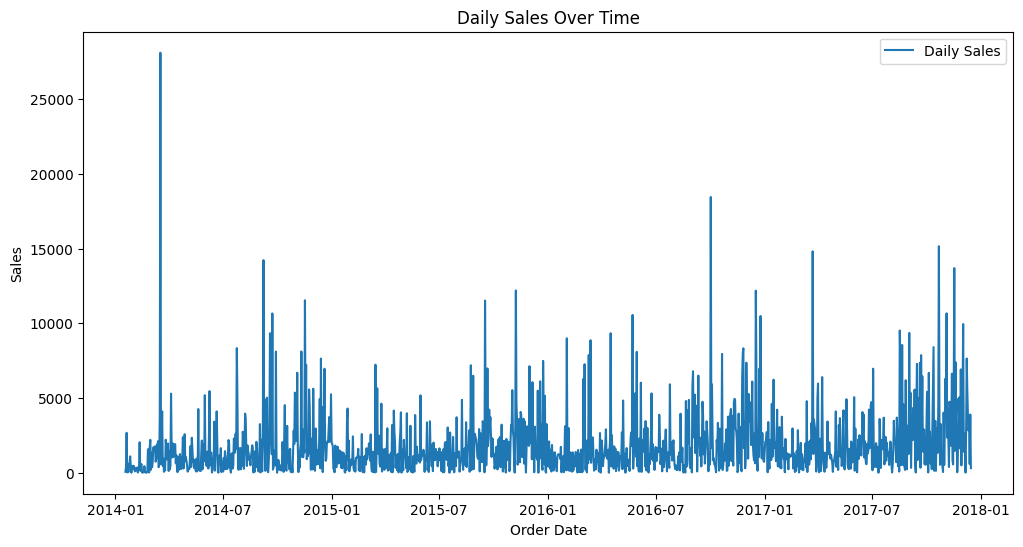

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(daily_aggregated['Order Date'], daily_aggregated['Sales'], label='Daily Sales')
plt.xlabel('Order Date')
plt.ylabel('Sales')
plt.title('Daily Sales Over Time')
plt.legend()
plt.show()

In [15]:
import numpy as np

Q1 = daily_aggregated['Sales'].quantile(0.25)
Q3 = daily_aggregated['Sales'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = daily_aggregated[
    (daily_aggregated['Sales'] < lower_bound) | 
    (daily_aggregated['Sales'] > upper_bound)
]

print(f"Number of potential outliers: {len(outliers)}")
outliers.head()


Number of potential outliers: 115


,Order Date,Sales,Quantity,Discount,Profit,Transaction Count,Segment_Consumer,Segment_Corporate,Segment_Home_Office,Category_Furniture,Category_OfficeSupplies,Category_Technology,Region_Central,Region_East,Region_South,Region_West,Order Quarter,Order DayOfWeek,Is Holiday Week
59,2014-03-18,28106.716,48.0,0.434271,-954.7089,11.0,0.000000,0.000000,1.000000,0.052032,0.067760,0.880208,0.000000,0.000000,0.841835,0.158165,1,Tuesday,No
77,2014-04-05,5295.098,54.0,0.003842,253.9044,13.0,0.145533,0.843990,0.010478,0.000000,0.994525,0.005475,0.164744,0.010478,0.824778,0.000000,2,Saturday,No
134,2014-06-01,5188.520,55.0,0.001263,1576.7509,11.0,0.174256,0.039333,0.786411,0.390104,0.439919,0.169977,0.761240,0.064504,0.174256,0.000000,2,Sunday,No
142,2014-06-09,5463.008,66.0,0.134930,629.0289,16.0,0.949306,0.024638,0.026056,0.591935,0.062001,0.346064,0.026056,0.000000,0.263829,0.710115,2,Monday,No
188,2014-07-25,8341.290,22.0,0.000000,384.5084,5.0,0.997363,0.000000,0.002637,0.009341,0.990659,0.000000,0.000000,0.000000,0.000000,1.000000,3,Friday,No


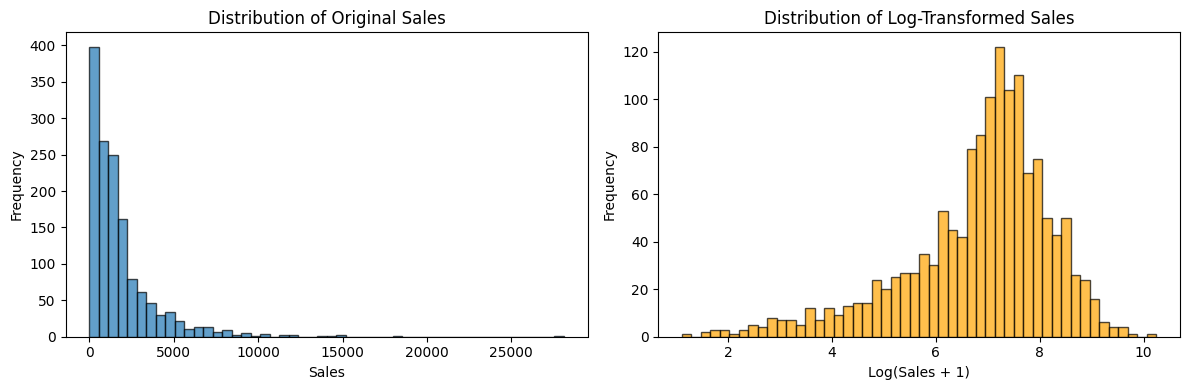

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Create a new column for the log-transformed sales
daily_aggregated['Log_Sales'] = np.log1p(daily_aggregated['Sales'])
# This uses log(1 + Sales) to handle zero values safely

# Step 2: Compare distributions of original Sales and Log-Transformed Sales
plt.figure(figsize=(12, 4))

# Original Sales distribution
plt.subplot(1, 2, 1)
plt.hist(daily_aggregated['Sales'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Distribution of Original Sales')
plt.xlabel('Sales')
plt.ylabel('Frequency')

# Log-Transformed Sales distribution
plt.subplot(1, 2, 2)
plt.hist(daily_aggregated['Log_Sales'], bins=50, alpha=0.7, color='orange', edgecolor='black')
plt.title('Distribution of Log-Transformed Sales')
plt.xlabel('Log(Sales + 1)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [17]:
from statsmodels.tsa.stattools import adfuller

# Suppose 'daily_aggregated' is your DataFrame, and 'Log_Sales' is your log-transformed sales column.
result = adfuller(daily_aggregated['Log_Sales'].dropna())  # dropna() in case of missing values

print('ADF Statistic:', result[0])
print('p-value:', result[1])
for key, value in result[4].items():
    print(f'Critical Values {key}, {value}')

ADF Statistic: -6.032428872097014
p-value: 1.407573073088491e-07
Critical Values 1%, -3.4349863902854607
Critical Values 5%, -2.863587640846308
Critical Values 10%, -2.567860154259632


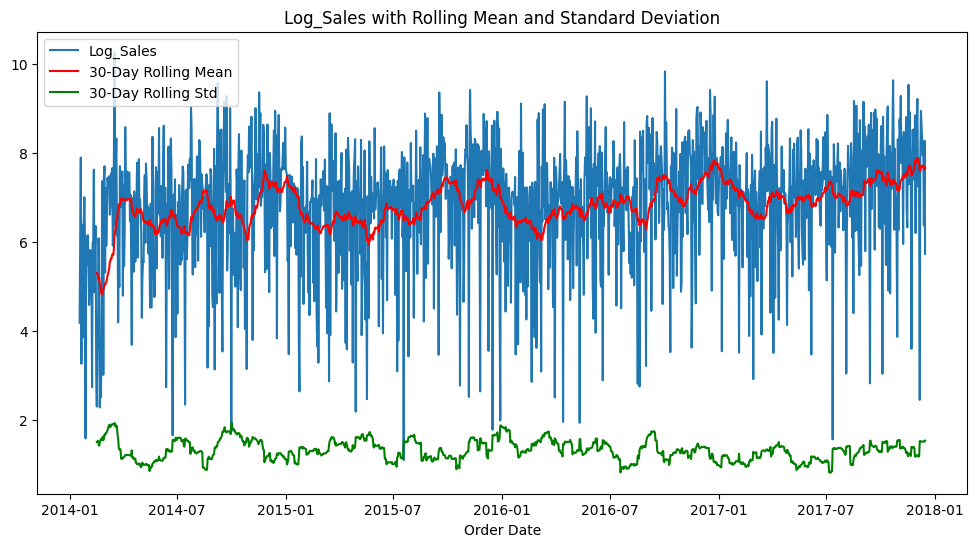

In [18]:
import matplotlib.pyplot as plt

# Set a window size (e.g., 30 days)
window_size = 30
rolling_mean = daily_aggregated['Log_Sales'].rolling(window=window_size).mean()
rolling_std = daily_aggregated['Log_Sales'].rolling(window=window_size).std()

plt.figure(figsize=(12,6))
plt.plot(daily_aggregated['Order Date'], daily_aggregated['Log_Sales'], label='Log_Sales')
plt.plot(daily_aggregated['Order Date'], rolling_mean, color='red', label=f'{window_size}-Day Rolling Mean')
plt.plot(daily_aggregated['Order Date'], rolling_std, color='green', label=f'{window_size}-Day Rolling Std')
plt.xlabel('Order Date')
plt.title('Log_Sales with Rolling Mean and Standard Deviation')
plt.legend()
plt.show()


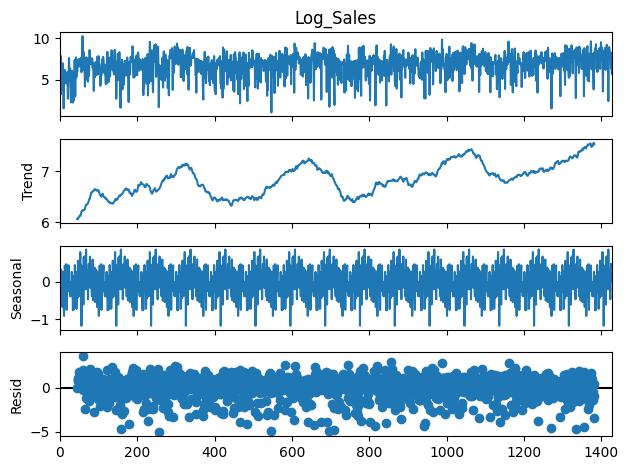

In [19]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

# Assuming a weekly cycle might be relevant (period=7 for daily data)
decomposition = seasonal_decompose(daily_aggregated['Log_Sales'], model='additive', period=90)
decomposition.plot()
plt.show()

In [20]:
# import pandas as pd
# import numpy as np
# import statsmodels.formula.api as smf
# import matplotlib.pyplot as plt

# # --- Step 1: Rename columns to remove spaces ---
# daily_aggregated = daily_aggregated.rename(columns={
#     "Order Date": "Order_Date",
#     "Sales": "Sales",  # assuming Sales is already fine
#     "Log Sales": "Log_Sales",  # if applicable; otherwise, adjust accordingly
#     "Transaction Count": "Transaction_Count",
#     "Order DayOfWeek": "Order_DayOfWeek",
#     "Order Quarter": "Order_Quarter",
#     "Is Holiday Week": "Is_Holiday_Week"
# })
# # If Log_Sales is not already created, create it using log1p transformation
# if 'Log_Sales' not in daily_aggregated.columns:
#     daily_aggregated['Log_Sales'] = np.log1p(daily_aggregated['Sales'])

# # --- Step 2: Create a time trend variable ---
# daily_aggregated['Time_Index'] = (daily_aggregated['Order_Date'] - daily_aggregated['Order_Date'].min()).dt.days

# # Ensure Activity is numeric (0/1) if not already; if it's categorical, convert it accordingly.
# if daily_aggregated['Activity'].dtype.name not in ['int64', 'float64']:
#     daily_aggregated['Activity'] = daily_aggregated['Activity'].astype(int)

# # --- Step 3: Define and fit the full regression model ---
# # We include the following predictors:
# # Time_Index, Quantity, Discount, Profit, Transaction_Count, Activity,
# # and categorical predictors: Order_Quarter, Order_DayOfWeek, Is_Holiday_Week
# formula_all = (
#     "Log_Sales ~ Time_Index + Quantity + Discount + Profit + Transaction_Count + Activity "
#     "+ C(Order_Quarter) + C(Order_DayOfWeek) + C(Is_Holiday_Week)"
# )

# model_all = smf.ols(formula=formula_all, data=daily_aggregated).fit()

# # Print the model summary to review coefficients, p-values, R-squared, etc.
# print(model_all.summary())

In [21]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

# --- Step 1: Rename columns to remove spaces ---
daily_aggregated = daily_aggregated.rename(columns={
    "Order Date": "Order_Date",
    "Sales": "Sales",  # assuming Sales is already fine
    "Log Sales": "Log_Sales",  # if applicable; otherwise, adjust accordingly
    "Transaction Count": "Transaction_Count",
    "Order DayOfWeek": "Order_DayOfWeek",
    "Order Quarter": "Order_Quarter",
    "Is Holiday Week": "Is_Holiday_Week"
})

# If Log_Sales is not already created, create it using log1p transformation
if 'Log_Sales' not in daily_aggregated.columns:
    daily_aggregated['Log_Sales'] = np.log1p(daily_aggregated['Sales'])

# --- Step 2: Create a time trend variable ---
daily_aggregated['Time_Index'] = (daily_aggregated['Order_Date'] - daily_aggregated['Order_Date'].min()).dt.days

# --- Step 3: Define and fit the full regression model ---
# We include the following predictors:
# Time_Index, Quantity, Discount, Profit, Transaction_Count,
# and categorical predictors: Order_Quarter, Order_DayOfWeek, Is_Holiday_Week
formula_all = (
    "Log_Sales ~ Time_Index + Quantity + Discount + Profit + Transaction_Count "
    "+ C(Order_Quarter) + C(Order_DayOfWeek) + C(Is_Holiday_Week)"
)

model_all = smf.ols(formula=formula_all, data=daily_aggregated).fit()

# Print the model summary
print(model_all.summary())


                            OLS Regression Results                            
Dep. Variable:              Log_Sales   R-squared:                       0.487
Model:                            OLS   Adj. R-squared:                  0.482
Method:                 Least Squares   F-statistic:                     89.40
Date:                Thu, 27 Mar 2025   Prob (F-statistic):          3.29e-192
Time:                        19:45:15   Log-Likelihood:                -2043.2
No. Observations:                1428   AIC:                             4118.
Df Residuals:                    1412   BIC:                             4203.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [26]:
# --- Step 2: Create log-transformed Sales if not already present ---
if 'Log_Sales' not in daily_aggregated.columns:
    daily_aggregated['Log_Sales'] = np.log1p(daily_aggregated['Sales'])

# --- Step 3: Create time index variable ---
daily_aggregated['Time_Index'] = (daily_aggregated['Order_Date'] - daily_aggregated['Order_Date'].min()).dt.days


# --- Step 4: Define regression formula (drop one segment to avoid multicollinearity) ---
formula_test = (
    "Log_Sales ~ Time_Index + Quantity + Profit + Transaction_Count "
    "+ Category_OfficeSupplies"
    "+ Region_Central + Region_East + Region_South "
    "+ C(Order_Quarter) + C(Order_DayOfWeek) + C(Is_Holiday_Week)"
)

# --- Step 5: Fit the model ---
model_test = smf.ols(formula=formula_test, data=daily_aggregated).fit(cov_type='HC3')

# --- Step 6: Print model summary ---
print(model_test.summary())


                            OLS Regression Results                            
Dep. Variable:              Log_Sales   R-squared:                       0.565
Model:                            OLS   Adj. R-squared:                  0.560
Method:                 Least Squares   F-statistic:                     51.73
Date:                Thu, 27 Mar 2025   Prob (F-statistic):          6.12e-141
Time:                        19:47:29   Log-Likelihood:                -1925.4
No. Observations:                1428   AIC:                             3889.
Df Residuals:                    1409   BIC:                             3989.
Df Model:                          18                                         
Covariance Type:                  HC3                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [83]:
# --- Step 1: Safe shift and log transforms ---
daily_aggregated['Profit_Squared'] = daily_aggregated['Profit'] ** 2

profit_shift = abs(daily_aggregated['Profit'].min()) + 1
daily_aggregated['Log_Profit'] = np.log1p(daily_aggregated['Profit'] + profit_shift)
daily_aggregated['Log_Profit_Squared'] = daily_aggregated['Log_Profit'] ** 2

daily_aggregated['Log_Transaction_Count'] = np.log1p(daily_aggregated['Transaction_Count'])

# --- Step 4: Define regression formula (drop one segment to avoid multicollinearity) ---
formula_transformed = (
    "Log_Sales ~ Time_Index + Quantity + Profit + Log_Transaction_Count "
    "+ Category_OfficeSupplies"
    "+ Region_Central + Region_East + Region_South "
    "+ C(Order_Quarter) + C(Order_DayOfWeek) + C(Is_Holiday_Week)"
)
# --- Step 5: Fit the model ---
model_test = smf.ols(formula=formula_transformed, data=daily_aggregated).fit(cov_type='HC3')

# --- Step 6: Show the summary ---
print(model_test.summary())

                            OLS Regression Results                            
Dep. Variable:              Log_Sales   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.652
Method:                 Least Squares   F-statistic:                     117.7
Date:                Thu, 27 Mar 2025   Prob (F-statistic):          3.81e-265
Time:                        20:33:18   Log-Likelihood:                -1758.2
No. Observations:                1428   AIC:                             3554.
Df Residuals:                    1409   BIC:                             3654.
Df Model:                          18                                         
Covariance Type:                  HC3                                         
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [70]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Prepare the design matrix by concatenating numeric predictors and dummy variables
predictors = daily_aggregated[['Time_Index', 'Quantity', 'Discount', 'Profit', 'Transaction_Count', 'Segment_Consumer', 'Segment_Corporate', 'Segment_Home_Office',
                        'Category_OfficeSupplies', 'Category_Technology', 'Category_Furniture']].copy()

dummies_quarter = pd.get_dummies(daily_aggregated['Order_Quarter'], prefix='Quarter', drop_first=True)
dummies_day = pd.get_dummies(daily_aggregated['Order_DayOfWeek'], prefix='Day', drop_first=True)
dummies_holiday = pd.get_dummies(daily_aggregated['Is_Holiday_Week'], prefix='Holiday', drop_first=True)

X = pd.concat([predictors, dummies_quarter, dummies_day, dummies_holiday], axis=1)

# Check for missing values
print("Missing values per column:")
print(X.isnull().sum())

# Convert all columns to numeric (float) if they are not already, forcing conversion errors to NaN.
X = X.apply(pd.to_numeric, errors='coerce')

# Fill any NaN values that may have been produced (choose a strategy; here we use 0)
X = X.fillna(0)
# Force all columns in X to be numeric float64 (ensures no 'object' or 'category' dtypes)
X = X.astype(float)

# Now calculate VIF for each predictor
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)


Missing values per column:
Time_Index                 0
Quantity                   0
Discount                   0
Profit                     0
Transaction_Count          0
Segment_Consumer           0
Segment_Corporate          0
Segment_Home_Office        0
Category_OfficeSupplies    0
Category_Technology        0
Category_Furniture         0
Quarter_2                  0
Quarter_3                  0
Quarter_4                  0
Day_Monday                 0
Day_Saturday               0
Day_Sunday                 0
Day_Thursday               0
Day_Tuesday                0
Day_Wednesday              0
Holiday_Yes                0
dtype: int64
                    Feature        VIF
0                Time_Index   1.144049
1                  Quantity  14.624174
2                  Discount   1.266892
3                    Profit   1.316929
4         Transaction_Count  15.176981
5          Segment_Consumer        inf
6         Segment_Corporate        inf
7       Segment_Home_Office        inf


C:\Users\rites\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


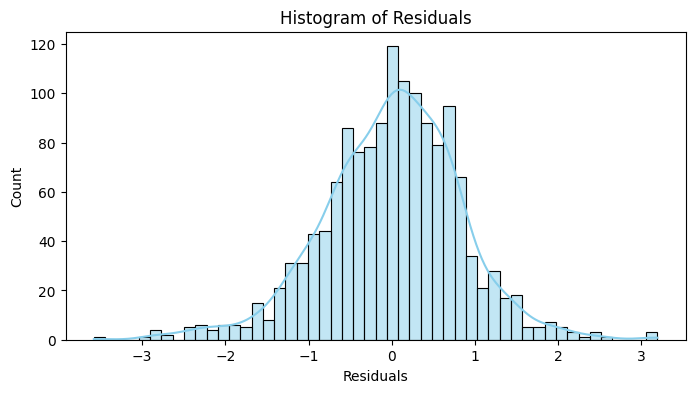

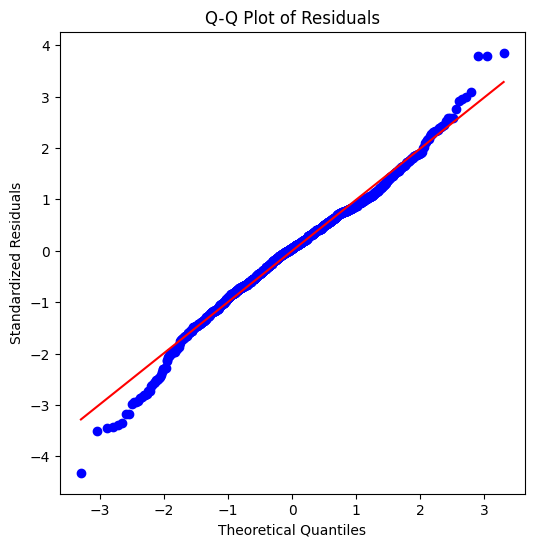

In [78]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

residuals = model_test.resid

# Histogram
plt.figure(figsize=(8, 4))
sns.histplot(residuals, kde=True, bins=50, color='skyblue')
plt.title("Histogram of Residuals")
plt.xlabel("Residuals")
plt.show()

# Q-Q plot
plt.figure(figsize=(6, 6))
standardized_resid = (residuals - residuals.mean()) / residuals.std()
stats.probplot(standardized_resid, dist="norm", plot=plt)
plt.title("Q-Q Plot of Residuals")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Standardized Residuals")
plt.show()


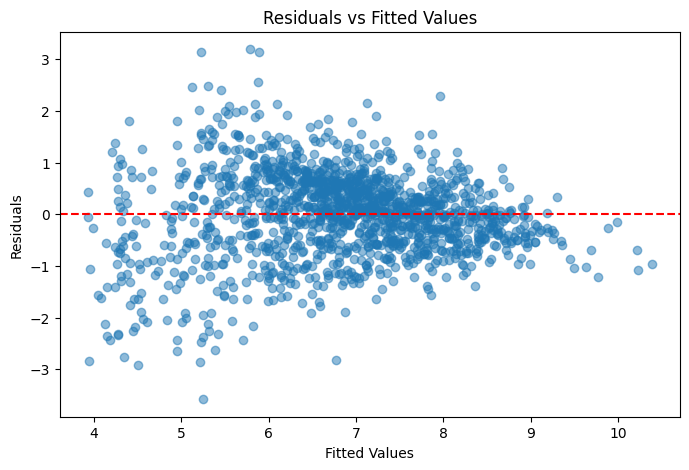

In [79]:
from statsmodels.stats.diagnostic import het_breuschpagan

# Residuals vs Fitted Values
plt.figure(figsize=(8, 5))
plt.scatter(model_test.fittedvalues, residuals, alpha=0.5)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel("Fitted Values")
plt.ylabel("Residuals")
plt.title("Residuals vs Fitted Values")
plt.show()

<Figure size 1200x600 with 0 Axes>

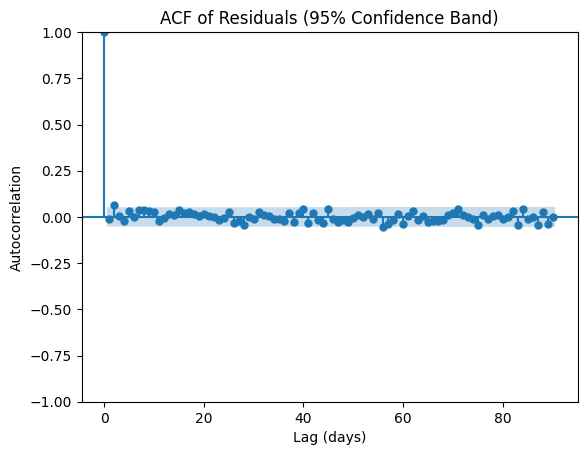

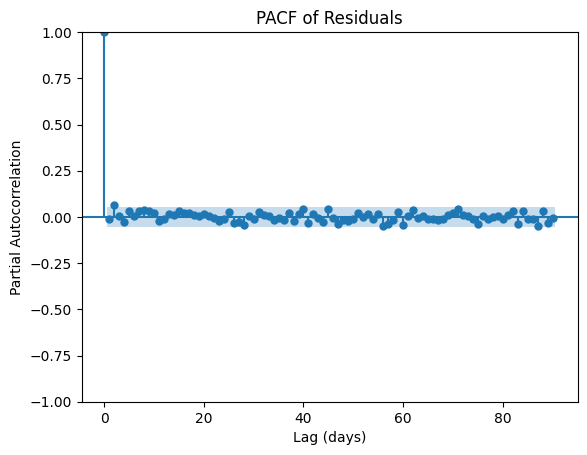

In [73]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# Get residuals from your final model
residuals = model_test.resid

# Plot ACF with 50% confidence bands
plt.figure(figsize=(12, 6))
plot_acf(residuals, lags=90, alpha=0.05)
plt.title("ACF of Residuals (95% Confidence Band)")
plt.xlabel("Lag (days)")
plt.ylabel("Autocorrelation")
plt.show()

from statsmodels.graphics.tsaplots import plot_pacf

# Assuming you have residuals from your regression
plot_pacf(residuals, lags=90, alpha=0.05)
plt.title("PACF of Residuals")
plt.xlabel("Lag (days)")
plt.ylabel("Partial Autocorrelation")
plt.show()


array([[<Axes: title={'center': 'Quantity'}>,
        <Axes: title={'center': 'Discount'}>],
       [<Axes: title={'center': 'Profit'}>,
        <Axes: title={'center': 'Transaction_Count'}>]], dtype=object)

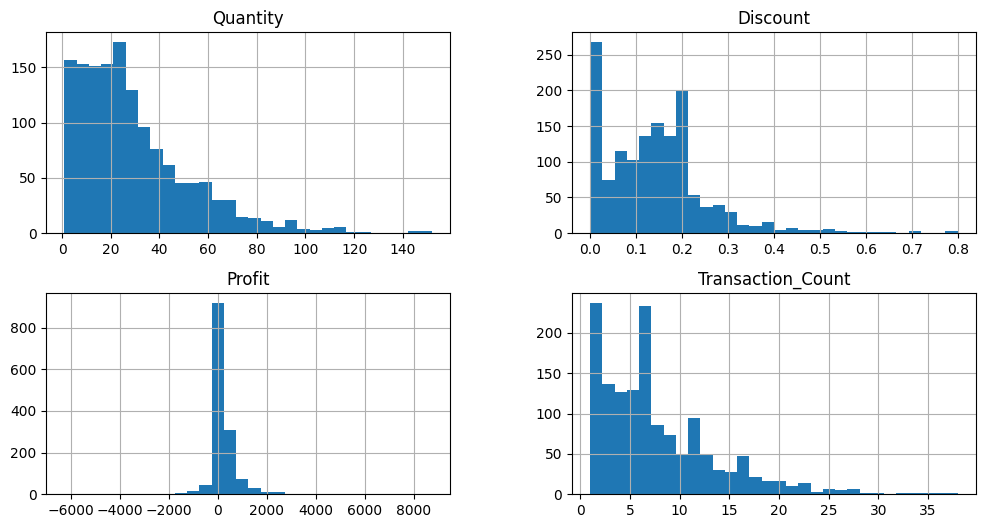

In [74]:
numeric_cols = ['Quantity', 'Discount', 'Profit', 'Transaction_Count']
daily_aggregated[numeric_cols].skew()
daily_aggregated[numeric_cols].hist(bins=30, figsize=(12, 6))



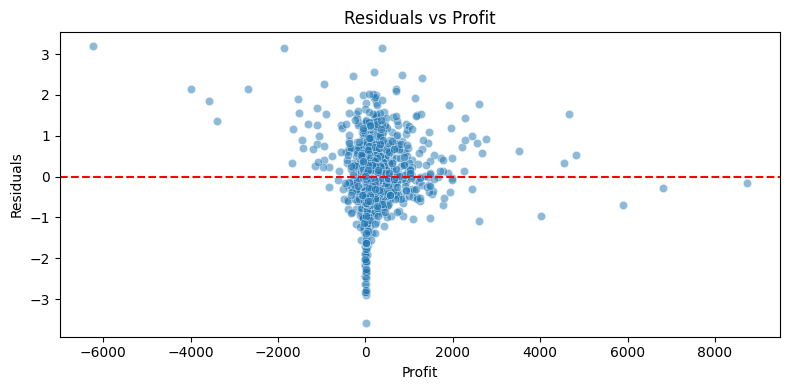

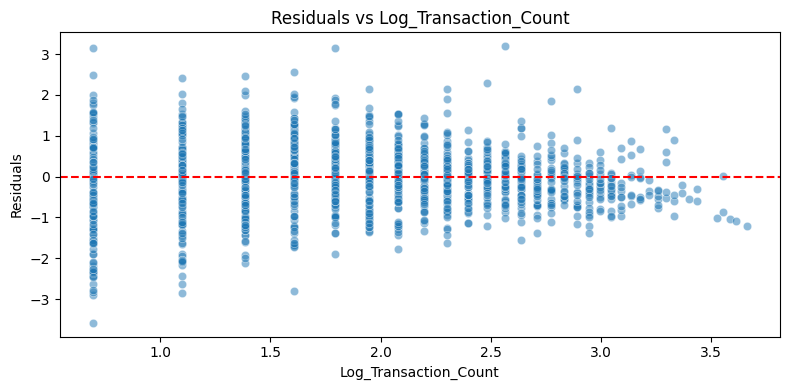

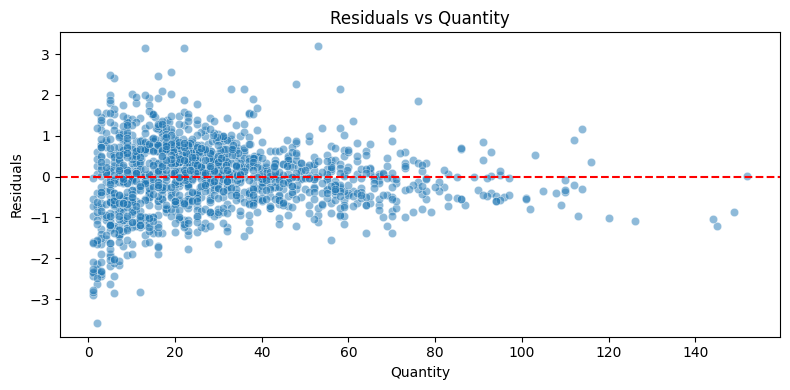

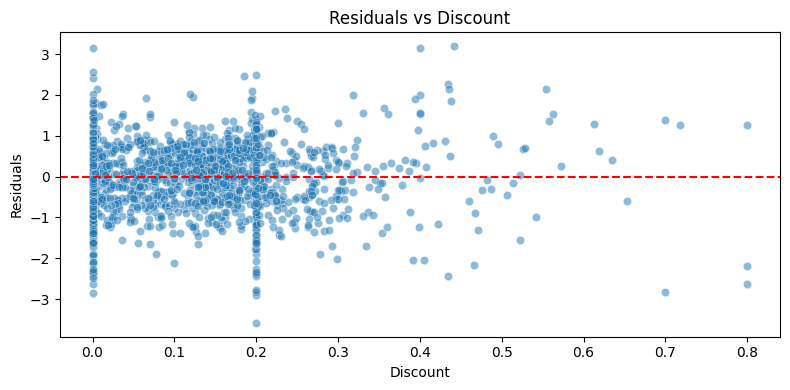

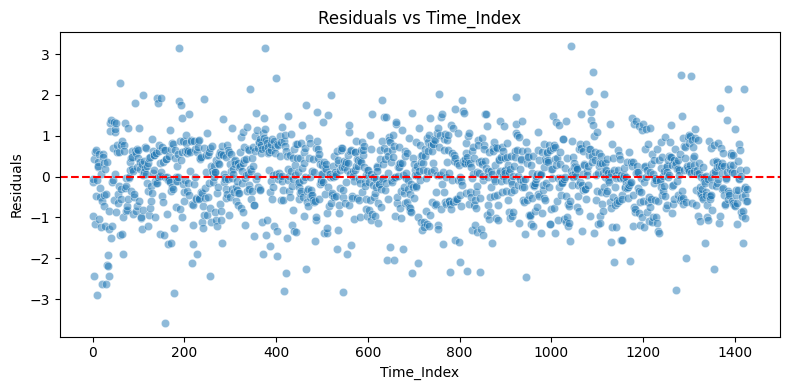

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

# Get residuals from your fitted model
residuals = model_test.resid

# Define the main numeric predictors
main_predictors = [
    'Profit', 'Log_Transaction_Count', 'Quantity', 'Discount', 'Time_Index'
]

# Define the proportion-based predictors (segment, category, region dummies)
proportion_predictors = [
    'Segment_Consumer', 'Segment_Corporate',
    'Category_OfficeSupplies', 'Category_Technology',
    'Region_Central', 'Region_East', 'Region_South'
]

# Plot residuals vs main predictors
for predictor in main_predictors:
    plt.figure(figsize=(8, 4))
    sns.scatterplot(x=daily_aggregated[predictor], y=residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel(predictor)
    plt.ylabel("Residuals")
    plt.title(f"Residuals vs {predictor}")
    plt.tight_layout()
    plt.show()



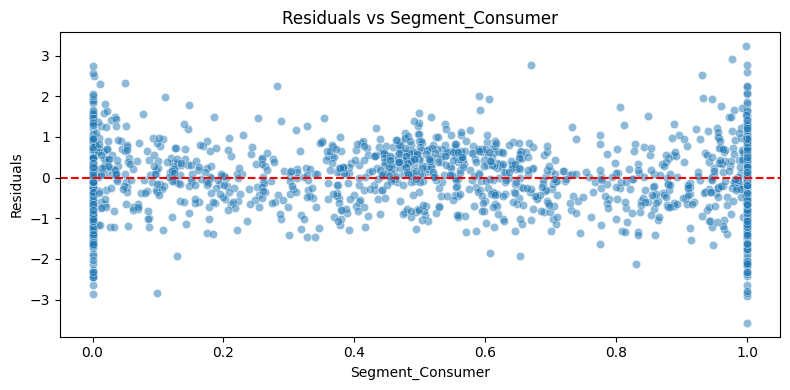

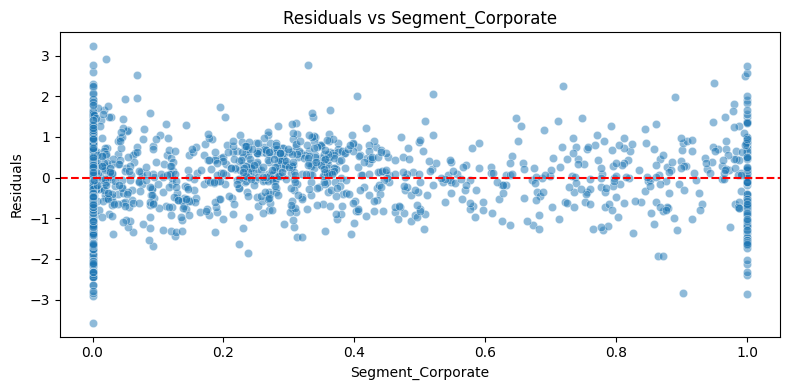

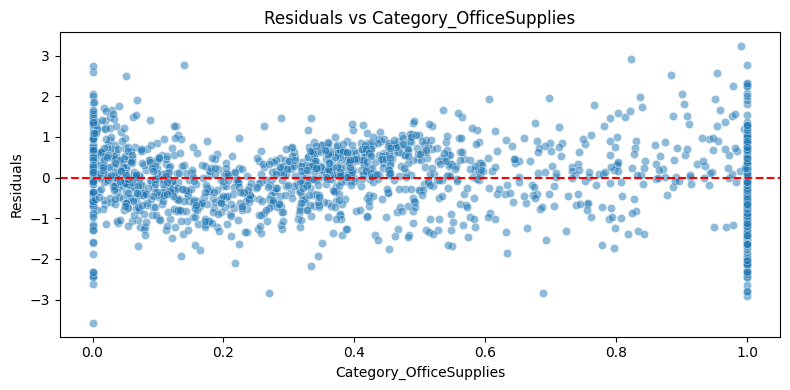

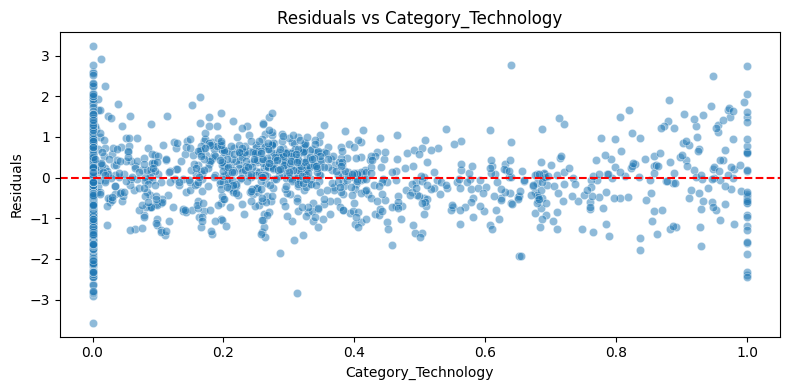

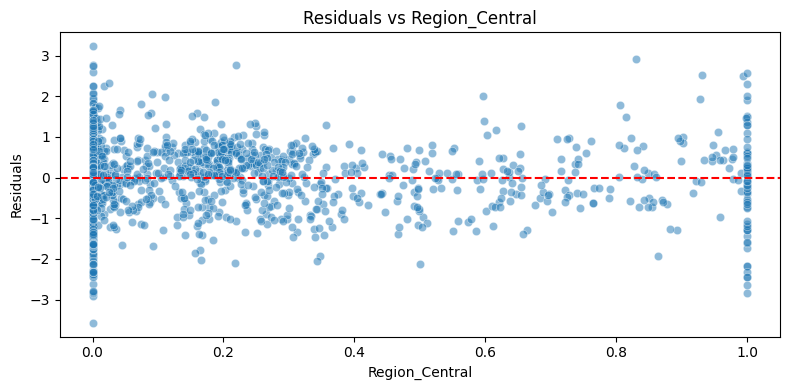

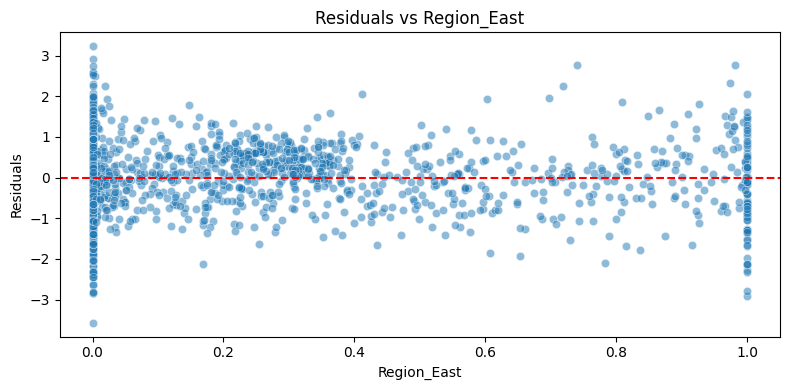

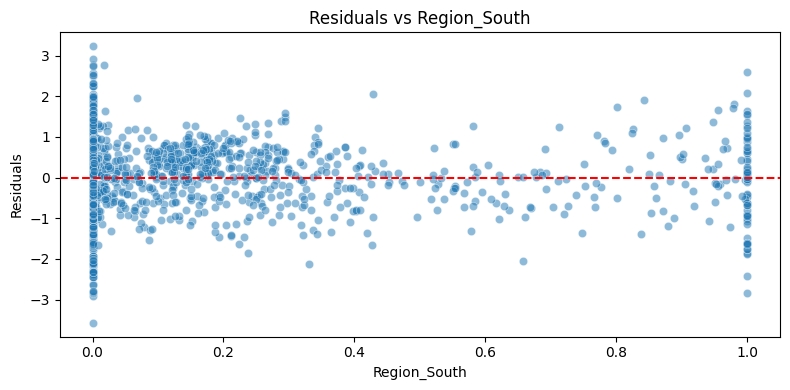

In [76]:
# Plot residuals vs proportion predictors
for predictor in proportion_predictors:
    plt.figure(figsize=(8, 4))
    sns.scatterplot(x=daily_aggregated[predictor], y=residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel(predictor)
    plt.ylabel("Residuals")
    plt.title(f"Residuals vs {predictor}")
    plt.tight_layout()
    plt.show()
